# Preprocessing the Data

In [36]:
from tqdm import tqdm_notebook as tqdm
import preprocessor as p
import numpy as np
import pandas
from math import log
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys
import re
from collections import defaultdict, Counter

In [37]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import torch.nn.functional as F

In [38]:
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [39]:
import matplotlib.pyplot as plt
import random

In [40]:
def preprocess(text):
    p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.EMOJI,p.OPT.HASHTAG)
    return p.tokenize(text).split()

In [41]:
data = pandas.read_csv('../HS_labeled_data.csv')
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [42]:
def preprocess(text):
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI ,p.OPT.HASHTAG)
    return p.tokenize(text).split()

In [43]:
def indexer(split_text):
    sent2idx = []
    for w in split_text:
        if w.lower() in word2idx:
            sent2idx.append(word2idx[w.lower()])
        else:
            sent2idx.append(word2idx['_UNK'])
            
    return sent2idx

In [44]:
train, valid = train_test_split(data)

In [45]:
train

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
19749,20188,3,1,2,0,1,RT @nickleberry_fin: You know a girl is a hoe ...
16214,16585,3,0,3,0,1,RT @LilReese300: @trippygalll @StoneCold__ bum...
10000,10272,3,0,3,0,1,"I aint saying you a bitch, But you be acting l..."
10129,10402,3,0,0,3,2,I can't sleep so ima watch Spongebob and eat c...
15648,16014,3,0,0,3,2,"RT @InNewZealand: The Knicks are still trash, ..."
...,...,...,...,...,...,...,...
14069,14409,3,0,0,3,2,RT @AIIAmericanGirI: &#127482;&#127480;\nFEC M...
3948,4065,6,2,4,0,1,@Liveitupjersey yeah...I try NOT to follow the...
3157,3238,3,0,3,0,1,@FabianMleal no bitch lol I'm not about that l...
12433,12745,3,0,3,0,1,"Like my 3rd grade teacher used to say, ""you ei..."


In [46]:
train['clean_text'] = train.tweet.apply(lambda x: preprocess(x.lower().strip()))

words = Counter()
for sent in tqdm(train.clean_text.values):
    words.update(w.lower() for w in sent)
   
# sort with most frequently occuring words first
words = sorted(words, key=words.get, reverse=True)
# add <pad> and <unk> token to vocab which will be used later
words = ['_PAD','_UNK'] + words

word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

train['sentence2idx'] = train.clean_text.apply(lambda x: indexer(x))
train['length'] = train.clean_text.apply(lambda x: len(x))
train['label'] = train['class']

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.

100%|██████████| 18587/18587 [00:00<00:00, 133445.96it/s]
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-pac

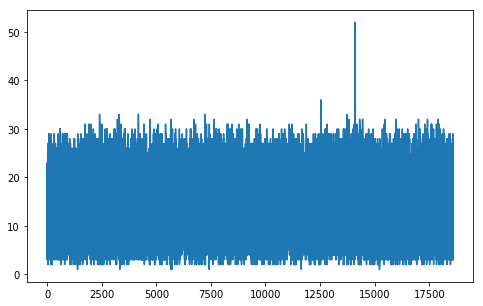

In [47]:
fig = plt.figure(figsize=(8,5))
ax = plt.plot(train.length.values)
plt.show()

In [48]:
valid['clean_text'] = valid.tweet.apply(lambda x: preprocess(x.strip()))

valid['sentence2idx'] = valid.clean_text.apply(lambda x: indexer(x))
valid['length'] = valid.clean_text.apply(lambda x: len(x))
valid['label'] = valid['class']

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_lau

In [49]:
class VectorizeData(Dataset):
    def __init__(self, df, maxlen=30):
        self.maxlen = maxlen
        self.df = df
#         print('Padding')
        self.df['padded_text'] = self.df.sentence2idx.apply(lambda x: self.pad_data(x))
        self.padded_text = list(self.df.padded_text)
        self.labels = list(self.df.label)
        self.lengths = list(self.df.length)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
#         lens = self.df.length[idx]
        X = self.padded_text[idx]
        y = self.labels[idx]
        lens = self.lengths[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded

In [50]:
train_loader = VectorizeData(train)
valid_loader = VectorizeData(valid)

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
tl = DataLoader(dataset=train_loader, batch_size=100, shuffle=True)
print(len(tl))

186


In [52]:
vl = DataLoader(dataset=valid_loader, batch_size=100, shuffle=False)
print(len(vl))

62


In [53]:
for i, samples in enumerate(tl):
    print(i)
    print(samples)
    break

0
[tensor([[   4,    5,   74,  ...,    0,    0,    0],
        [2712,   16,    3,  ...,    0,    0,    0],
        [   4,    5,    4,  ...,    0,    0,    0],
        ...,
        [   2,   12,  177,  ...,    0,    0,    0],
        [  46,   17, 1857,  ...,    0,    0,    0],
        [   4,    5,    9,  ...,    0,    0,    0]]), tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 1]), tensor([21, 22, 21, 12, 23, 19, 26, 25, 20, 15,  6, 22,  7,  9, 19, 24,  7, 20,
        24, 27, 15,  9, 26, 16, 27, 11, 24, 18, 14,  4, 18, 18, 18,  4,  5, 12,
        13,  3,  8, 11, 27, 19, 18, 15, 28,  8,  5, 19, 18,  8, 23, 28, 17, 24,
        17, 27, 21, 11, 12, 15,  8, 10,  2,  5, 19,  6, 12, 21,  8, 10,  3,  9,
        

In [54]:
for i, samples in enumerate(vl):
    print(i)
    print(samples)
    break

0
[tensor([[  39,    9,   71,  ...,    0,    0,    0],
        [   2,  264,    9,  ...,    0,    0,    0],
        [  95,    9, 1792,  ...,    0,    0,    0],
        ...,
        [   4,    5,   32,  ...,    0,    0,    0],
        [  46,   26,  185,  ...,    0,    0,    0],
        [  91,    6,   33,  ...,    0,    0,    0]]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        1, 1, 1, 0]), tensor([22, 22,  9,  4, 14, 12,  8, 15, 11, 26,  7, 18,  4, 21, 14, 24, 13,  7,
        24, 24, 16, 17,  9, 20,  9, 16, 14, 17, 13,  3,  9, 16, 22, 18, 13,  4,
        27, 10,  5, 28, 23, 13,  4, 31,  7,  2, 15,  8, 13, 24, 23, 20,  9,  4,
        12, 19, 21, 21,  5, 12, 12, 26,  7, 12, 11, 24,  5,  4,  8, 12, 18, 15,
        

## PMI

In [55]:
def computePMIMatrix(listOfTokenizedSentences):
    wordCounts = defaultdict(lambda:0)
    
    print('Calculating Word Probabilities')
    for tokenizedSent in tqdm(listOfTokenizedSentences):
        for word in set(tokenizedSent):
            wordCounts[word] += 1
            
    for key in wordCounts:
        wordCounts[key] = wordCounts[key] / len(listOfTokenizedSentences)
    
    pairwiseCounts = defaultdict(lambda:defaultdict(lambda:0))
    
    print('Calculating PairWise Probabilities')
    for tokenizedSent in tqdm(listOfTokenizedSentences):
        sentWords = set(tokenizedSent)
        
        for i in sentWords:
            for j in sentWords:
                pairwiseCounts[i][j] += 1 / len(listOfTokenizedSentences)
        
    return wordCounts, pairwiseCounts

In [56]:
a,b = computePMIMatrix(list(train['clean_text']))


100%|██████████| 18587/18587 [00:00<00:00, 131559.72it/s]

  0%|          | 0/18587 [00:00<?, ?it/s]

Calculating Word Probabilities
Calculating PairWise Probabilities



100%|██████████| 18587/18587 [00:02<00:00, 8701.59it/s]


In [57]:
def PPMI(w1,w2):
    try:
        return max( 0,log(b[w1][w2]) - (log(a[w1])+log(a[w2])) )
    except:
        return 0

In [58]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    # return sparse_to_tuple(adj_normalized)
    return adj_normalized.A

def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (
        2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    # t_k.append(sp.eye(adj.shape[0]))
    # t_k.append(scaled_laplacian)
    t_k.append(sp.eye(adj.shape[0]).A)
    t_k.append(scaled_laplacian.A)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    # return sparse_to_tuple(t_k)
    return t_k

## RecModel

In [59]:
class RecArch(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidir, rnnType,device):
        super(RecArch, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        self.rnnType = rnnType
        self.bidirectional = bidir
        
        if self.bidirectional:
            self.numDirs = 2
        else:
            self.numDirs = 1
        
        self.emb = nn.Embedding(self.vocab_size, embedding_dim)
        
        if self.rnnType == 'lstm':
            self.recNN = nn.LSTM(embedding_dim,hidden_dim, num_layers,batch_first=True,bidirectional=self.bidirectional)
            
        if self.rnnType == 'gru':
            self.recNN = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True,bidirectional=self.bidirectional)
            
        if self.rnnType == 'rnn':
            self.recNN = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh',bidirectional=self.bidirectional)
        
        self.fc = nn.Linear(self.numDirs*hidden_dim,output_dim)
    
    def encode(self,x):
        embs = self.emb(x)
        embs = embs.view(x.size(0),-1,self.embedding_dim).to(self.device)
        
        h0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
        
        if self.rnnType == 'lstm':        
            c0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
            
            out,(hn,cn) = self.recNN(embs,(h0,c0))
        
        else:
            out, hn = self.recNN(embs, h0)
        
#         print(out[:,-1,:].shape)
        return out[:, -1, :]
    
    def forward(self,x):
        embs = self.emb(x)
        embs = embs.view(x.size(0),-1,self.embedding_dim).to(self.device)
        
        h0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
        
        if self.rnnType == 'lstm':        
            c0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
            
            out,(hn,cn) = self.recNN(embs,(h0,c0))
        
        else:
            out, hn = self.recNN(embs, h0)
        
#         print(out[:,-1,:].shape)
        out = self.fc(out[:, -1, :])
        return out

### Optimal combination seems to be with GRU of 50 units and 1 layer

In [60]:
vocab_size = len(words)
embedding_dim = 256
n_hidden = 50
n_out = 3
num_layers = 1
rnnType = 'lstm'
bidir = False

if torch.cuda.is_available():
    device = 'cuda:1'
else:
    device = 'cpu'

In [61]:
model = RecArch(vocab_size,embedding_dim,n_hidden,n_out,num_layers,bidir,rnnType,device)
model = model.to(device)
model.float()

RecArch(
  (emb): Embedding(27765, 256)
  (recNN): LSTM(256, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

# Pretraining Text Encoder

In [62]:
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.01)
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()

seq_dim = 30
num_epochs = 200

train_losses_iterwise = []
recall_iterwise = []
precision_iterwise = []
accuracy_iterwise = []
f1score_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,label,lengths) in enumerate(tl):

        text = Variable(text.view(-1, seq_dim, 1)).to(device)
        label = Variable(label).to(device)
        
#         print(sexism_label)
        
        optimizer.zero_grad()
        outputs = model(text)
        
#         print(outputs)
        
        loss = criterion(outputs, label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        correct = 0
        total = 0

        allLabels = []
        allPreds = []
        probPreds = []

        for i, (text,label,lengths) in enumerate(vl):
            labels=[]
            text = Variable(text.view(-1, seq_dim, 1)).to(device)
            label = Variable(label).to(device)

            predicted = model(text)
            predicted =  torch.softmax(predicted,1)
            probPreds.append(predicted)
            predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
    #                 print(predicted)
    #                 print(sexism_label)
            allLabels += (label.cpu().numpy().tolist())
            allPreds += (predicted)

        valacc = accuracy_score(allLabels, allPreds)
        recscore = recall_score(allLabels, allPreds,average='macro')
        precscore = precision_score(allLabels, allPreds,average='macro')
        f1score = f1_score(allLabels, allPreds,average='macro')
#         roc = roc_auc_score(allLabels,allPreds)
        cr = classification_report(allLabels, allPreds)
#         print(f'acc: {valacc} AUC {roc}')
        print(cr)

        train_losses_iterwise.append(np.mean(train_losses))


  0%|          | 1/200 [00:01<03:35,  1.09s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       370
           1       0.77      1.00      0.87      4788
           2       0.00      0.00      0.00      1038

   micro avg       0.77      0.77      0.77      6196
   macro avg       0.26      0.33      0.29      6196
weighted avg       0.60      0.77      0.67      6196




 26%|██▌       | 51/200 [00:43<02:13,  1.12it/s]

              precision    recall  f1-score   support

           0       0.15      0.22      0.17       370
           1       0.86      0.92      0.89      4788
           2       0.78      0.39      0.52      1038

   micro avg       0.79      0.79      0.79      6196
   macro avg       0.60      0.51      0.53      6196
weighted avg       0.80      0.79      0.78      6196




 50%|█████     | 101/200 [01:26<01:28,  1.12it/s]

              precision    recall  f1-score   support

           0       0.15      0.25      0.19       370
           1       0.85      0.91      0.88      4788
           2       0.79      0.36      0.49      1038

   micro avg       0.78      0.78      0.78      6196
   macro avg       0.60      0.51      0.52      6196
weighted avg       0.80      0.78      0.78      6196




 76%|███████▌  | 151/200 [02:08<00:43,  1.12it/s]

              precision    recall  f1-score   support

           0       0.15      0.25      0.19       370
           1       0.86      0.91      0.88      4788
           2       0.79      0.39      0.53      1038

   micro avg       0.78      0.78      0.78      6196
   macro avg       0.60      0.52      0.53      6196
weighted avg       0.81      0.78      0.78      6196




100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


# Training Conv Net

In [63]:
tl = DataLoader(dataset=train_loader, batch_size=1, shuffle=True)
vl = DataLoader(dataset=valid_loader, batch_size=1, shuffle=True)

In [64]:
def computeAdjMatrix(text):
    text = text.reshape(-1).tolist()
    words = [idx2word[idx] for idx in text]
    tf = Counter(words)
    matrix = []
    for i in range(len(words)):
        row = []
        for j in range(len(words)):
            row.append(PPMI(words[i],words[j]))
        row.append(1)
        matrix.append(row)
        
    matrix.append([tf[word] for word in words]+[1])
    return preprocess_adj(np.array(matrix))

In [65]:
class GraphConvLayer(nn.Module):
    def __init__(self, in_size, out_size):
        super(GraphConvLayer,self).__init__()
        
        self.weight = nn.parameter.Parameter(torch.FloatTensor(in_size, out_size))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        
    def forward(self,X,A_hat):
        X = torch.mm(X, self.weight)
        X = F.relu(torch.mm(A_hat, X))
        
        return X

In [66]:
class GraphConvNet(nn.Module):
    def __init__(self,feature_dim):
        super(GraphConvNet, self).__init__()
        self.graphlayer1 = GraphConvLayer(feature_dim,feature_dim)
        self.graphlayer2 = GraphConvLayer(feature_dim,feature_dim)
        
        self.fc = nn.Linear(50,3)
        
    def forward(self,X,A_hat):
        A_hat = torch.tensor(A_hat).float()
        X1 = self.graphlayer1(X,A_hat)
        X2 = self.graphlayer2(X1,A_hat)
#         print(X2)
        
        out = self.fc(X2)
        return out

In [67]:
class gcn(nn.Module):
    def __init__(self, X_size, bias=True): # X_size = num features
        super(gcn, self).__init__()
        self.weight = nn.parameter.Parameter(torch.FloatTensor(X_size, 50))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(50, 50))
        var2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,var2)
        
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(50)) # dim 2 in weight 1
            self.bias.data.normal_(0,var)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(50)) # dim 2 in weight 2
            self.bias2.data.normal_(0,var2)
        else:
            self.register_parameter("bias", None)
        
        self.fc = nn.Linear(50,3)
        
    def forward(self, X, A_hat): ### 2-layer GCN architecture
        A_hat = torch.tensor(A_hat, requires_grad=False).float()
        
        X = torch.mm(X, self.weight)
        if self.bias is not None:
            X = (X + self.bias)
            
        X = F.relu(torch.mm(A_hat, X))
        X = torch.mm(X, self.weight2)
        
        if self.bias2 is not None:
            X = (X + self.bias2)
        X = F.relu(torch.mm(A_hat, X))
        
        return self.fc(X)
    
    def getScores(self,X,A_hat):
        A_hat = torch.tensor(A_hat, requires_grad=False).float()

### With Frozen FC from Seq Encoder

In [33]:
gcnModel = gcn(50).to(device)
gcnModel.fc.load_state_dict(model.fc.state_dict())
gcnModel.fc.weight.requires_grad = False
gcnModel.fc.bias.requires_grad = False

In [34]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gcnModel.parameters()), lr=0.2)

In [ ]:
for epoch in tqdm_notebook(range(5)):
    train_losses = []
    for i, (text,label,lengths) in tqdm(enumerate(tl),total=len(tl)):
        textencs = model.encode(text.reshape(seq_dim,-1,1).to(device))
        sentenc = model.encode(text.reshape(-1, seq_dim, 1).to(device))
        embeds = torch.cat([textencs,sentenc])
        label = Variable(label).to(device)
        
        adj_matrix = torch.tensor(computeAdjMatrix(text)).to(device)
        
        optimizer.zero_grad()
        outputs = gcnModel(embeds,adj_matrix)
        
        loss = criterion(outputs[-1].reshape(1,-1), label)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    print(np.average(train_losses))

### With Finetuned FC

In [68]:
gcnModel = gcn(50).to(device)
gcnModel.fc.load_state_dict(model.fc.state_dict())

<All keys matched successfully>

In [69]:
optimizer = optim.Adam(gcnModel.parameters(), lr=0.2)

In [70]:
for epoch in tqdm_notebook(range(5)):
    train_losses = []
    for i, (text,label,lengths) in tqdm(enumerate(tl),total=len(tl)):
        textencs = model.encode(text.reshape(seq_dim,-1,1).to(device))
        sentenc = model.encode(text.reshape(-1, seq_dim, 1).to(device))
        embeds = torch.cat([textencs,sentenc])
        label = Variable(label).to(device)
        
        adj_matrix = torch.tensor(computeAdjMatrix(text)).to(device)
        
        optimizer.zero_grad()
        outputs = gcnModel(embeds,adj_matrix)
        
        loss = criterion(outputs[-1].reshape(1,-1), label)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    print(np.average(train_losses))

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.




  0%|          | 0/18587 [00:00<?, ?it/s]/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 11/18587 [00:00<03:01, 102.56it/s]

  0%|          | 22/18587 [00:00<02:57, 104.56it/s]

  0%|          | 33/18587 [00:00<02:55, 105.61it/s]

  0%|          | 45/18587 [00:00<02:53, 106.87it/s]

  0%|          | 56/18587 [00:00<02:52, 107.28it/s]

  0%|          | 67/18587 [00:00<02:51, 107.84it/s]

  0%|          | 77/18587 [00:00<02:56, 104.92it/s]

  0%|          | 88/18587 [00:00<02:55, 105.65it/s]

  1%|          | 99/18587 [00:00<02:53, 106.40it/s]

  1%|          | 111/18587 [00:01<02:51, 107.51it/s]

  1%|          | 122/18587 [00:01<02:50, 108.13it/s]

  1%|          | 133/18587 [00:01<02:50, 108.28it/s]

  1%|          | 

 17%|█▋        | 3136/18587 [00:28<02:19, 110.86it/s]

 17%|█▋        | 3148/18587 [00:28<02:18, 111.13it/s]

 17%|█▋        | 3160/18587 [00:28<02:19, 110.67it/s]

 17%|█▋        | 3172/18587 [00:28<02:19, 110.67it/s]

 17%|█▋        | 3184/18587 [00:28<02:18, 111.11it/s]

 17%|█▋        | 3196/18587 [00:28<02:18, 110.93it/s]

 17%|█▋        | 3208/18587 [00:28<02:18, 110.93it/s]

 17%|█▋        | 3220/18587 [00:28<02:18, 111.10it/s]

 17%|█▋        | 3232/18587 [00:29<02:18, 110.95it/s]

 17%|█▋        | 3244/18587 [00:29<02:18, 110.55it/s]

 18%|█▊        | 3256/18587 [00:29<02:18, 110.68it/s]

 18%|█▊        | 3268/18587 [00:29<02:18, 110.74it/s]

 18%|█▊        | 3280/18587 [00:29<02:18, 110.89it/s]

 18%|█▊        | 3292/18587 [00:29<02:17, 110.88it/s]

 18%|█▊        | 3304/18587 [00:29<02:17, 110.93it/s]

 18%|█▊        | 3316/18587 [00:29<02:17, 110.72it/s]

 18%|█▊        | 3328/18587 [00:29<02:17, 110.98it/s]

 18%|█▊        | 3340/18587 [00:30<02:17, 111.07it/s]

 18%|█▊   

 34%|███▍      | 6345/18587 [00:56<01:48, 112.49it/s]

 34%|███▍      | 6357/18587 [00:56<01:48, 112.41it/s]

 34%|███▍      | 6369/18587 [00:57<01:48, 112.54it/s]

 34%|███▍      | 6381/18587 [00:57<01:48, 112.11it/s]

 34%|███▍      | 6393/18587 [00:57<01:48, 111.97it/s]

 34%|███▍      | 6405/18587 [00:57<01:48, 111.77it/s]

 35%|███▍      | 6417/18587 [00:57<01:48, 112.01it/s]

 35%|███▍      | 6429/18587 [00:57<01:48, 112.05it/s]

 35%|███▍      | 6441/18587 [00:57<01:48, 112.14it/s]

 35%|███▍      | 6453/18587 [00:57<01:47, 112.47it/s]

 35%|███▍      | 6465/18587 [00:57<01:48, 112.19it/s]

 35%|███▍      | 6477/18587 [00:58<01:48, 111.93it/s]

 35%|███▍      | 6489/18587 [00:58<01:47, 112.42it/s]

 35%|███▍      | 6501/18587 [00:58<01:47, 112.16it/s]

 35%|███▌      | 6513/18587 [00:58<01:47, 112.28it/s]

 35%|███▌      | 6525/18587 [00:58<01:47, 112.34it/s]

 35%|███▌      | 6537/18587 [00:58<01:47, 112.02it/s]

 35%|███▌      | 6549/18587 [00:58<01:47, 112.05it/s]

 35%|███▌ 

 51%|█████▏    | 9561/18587 [01:25<01:20, 112.23it/s]

 52%|█████▏    | 9573/18587 [01:25<01:20, 112.42it/s]

 52%|█████▏    | 9585/18587 [01:25<01:20, 112.38it/s]

 52%|█████▏    | 9597/18587 [01:25<01:19, 112.52it/s]

 52%|█████▏    | 9609/18587 [01:25<01:19, 112.47it/s]

 52%|█████▏    | 9621/18587 [01:26<01:19, 112.51it/s]

 52%|█████▏    | 9633/18587 [01:26<01:19, 112.49it/s]

 52%|█████▏    | 9645/18587 [01:26<01:20, 110.80it/s]

 52%|█████▏    | 9657/18587 [01:26<01:21, 110.01it/s]

 52%|█████▏    | 9669/18587 [01:26<01:21, 109.80it/s]

 52%|█████▏    | 9680/18587 [01:26<01:21, 109.62it/s]

 52%|█████▏    | 9691/18587 [01:26<01:21, 109.07it/s]

 52%|█████▏    | 9702/18587 [01:26<01:21, 109.10it/s]

 52%|█████▏    | 9714/18587 [01:26<01:20, 109.58it/s]

 52%|█████▏    | 9726/18587 [01:27<01:19, 110.81it/s]

 52%|█████▏    | 9738/18587 [01:27<01:19, 111.43it/s]

 52%|█████▏    | 9750/18587 [01:27<01:18, 112.23it/s]

 53%|█████▎    | 9762/18587 [01:27<01:18, 112.48it/s]

 53%|█████

 68%|██████▊   | 12713/18587 [01:53<00:51, 114.46it/s]

 68%|██████▊   | 12725/18587 [01:53<00:51, 114.57it/s]

 69%|██████▊   | 12737/18587 [01:53<00:51, 114.60it/s]

 69%|██████▊   | 12749/18587 [01:53<00:51, 114.18it/s]

 69%|██████▊   | 12761/18587 [01:53<00:51, 114.15it/s]

 69%|██████▊   | 12773/18587 [01:53<00:50, 114.15it/s]

 69%|██████▉   | 12785/18587 [01:54<00:50, 113.98it/s]

 69%|██████▉   | 12797/18587 [01:54<00:50, 114.07it/s]

 69%|██████▉   | 12809/18587 [01:54<00:50, 114.17it/s]

 69%|██████▉   | 12821/18587 [01:54<00:50, 114.33it/s]

 69%|██████▉   | 12833/18587 [01:54<00:50, 113.76it/s]

 69%|██████▉   | 12845/18587 [01:54<00:50, 113.75it/s]

 69%|██████▉   | 12857/18587 [01:54<00:50, 113.66it/s]

 69%|██████▉   | 12869/18587 [01:54<00:50, 113.87it/s]

 69%|██████▉   | 12881/18587 [01:54<00:50, 113.73it/s]

 69%|██████▉   | 12893/18587 [01:55<00:50, 113.60it/s]

 69%|██████▉   | 12905/18587 [01:55<00:49, 113.89it/s]

 69%|██████▉   | 12917/18587 [01:55<00:49, 113.7

 85%|████████▌ | 15880/18587 [02:21<00:23, 113.53it/s]

 86%|████████▌ | 15892/18587 [02:21<00:23, 113.45it/s]

 86%|████████▌ | 15904/18587 [02:21<00:23, 113.49it/s]

 86%|████████▌ | 15916/18587 [02:21<00:23, 113.77it/s]

 86%|████████▌ | 15928/18587 [02:21<00:23, 113.68it/s]

 86%|████████▌ | 15940/18587 [02:21<00:23, 114.07it/s]

 86%|████████▌ | 15952/18587 [02:22<00:23, 113.93it/s]

 86%|████████▌ | 15964/18587 [02:22<00:22, 114.07it/s]

 86%|████████▌ | 15976/18587 [02:22<00:22, 114.19it/s]

 86%|████████▌ | 15988/18587 [02:22<00:22, 113.92it/s]

 86%|████████▌ | 16000/18587 [02:22<00:22, 113.81it/s]

 86%|████████▌ | 16012/18587 [02:22<00:22, 113.71it/s]

 86%|████████▌ | 16024/18587 [02:22<00:22, 114.01it/s]

 86%|████████▋ | 16036/18587 [02:22<00:22, 113.79it/s]

 86%|████████▋ | 16048/18587 [02:22<00:22, 113.81it/s]

 86%|████████▋ | 16060/18587 [02:23<00:22, 113.56it/s]

 86%|████████▋ | 16072/18587 [02:23<00:22, 113.74it/s]

 87%|████████▋ | 16084/18587 [02:23<00:21, 113.8

2.22233251684637




  0%|          | 24/18587 [00:00<02:41, 114.69it/s]

  0%|          | 36/18587 [00:00<02:41, 114.73it/s]

  0%|          | 48/18587 [00:00<02:41, 114.67it/s]

  0%|          | 60/18587 [00:00<02:41, 114.74it/s]

  0%|          | 72/18587 [00:00<02:41, 114.76it/s]

  0%|          | 84/18587 [00:00<02:42, 114.16it/s]

  1%|          | 96/18587 [00:00<02:42, 113.97it/s]

  1%|          | 108/18587 [00:00<02:41, 114.19it/s]

  1%|          | 120/18587 [00:01<02:41, 114.07it/s]

  1%|          | 132/18587 [00:01<02:41, 113.95it/s]

  1%|          | 144/18587 [00:01<02:42, 113.67it/s]

  1%|          | 156/18587 [00:01<02:41, 113.82it/s]

  1%|          | 168/18587 [00:01<02:42, 113.63it/s]

  1%|          | 180/18587 [00:01<02:41, 114.06it/s]

  1%|          | 192/18587 [00:01<02:41, 113.85it/s]

  1%|          | 204/18587 [00:01<02:41, 113.96it/s]

  1%|          | 216/18587 [00:01<02:41, 113.86it/s]

  1%|          | 228/18587 [00:01<02:41, 114.00it/s]

  1%|▏         | 240/18587 [00:02

 17%|█▋        | 3246/18587 [00:28<02:13, 115.04it/s]

 18%|█▊        | 3258/18587 [00:28<02:13, 114.94it/s]

 18%|█▊        | 3270/18587 [00:28<02:13, 115.02it/s]

 18%|█▊        | 3282/18587 [00:28<02:13, 115.00it/s]

 18%|█▊        | 3294/18587 [00:28<02:13, 114.45it/s]

 18%|█▊        | 3306/18587 [00:28<02:13, 114.66it/s]

 18%|█▊        | 3318/18587 [00:29<02:13, 114.54it/s]

 18%|█▊        | 3330/18587 [00:29<02:13, 114.56it/s]

 18%|█▊        | 3342/18587 [00:29<02:13, 114.56it/s]

 18%|█▊        | 3354/18587 [00:29<02:13, 114.45it/s]

 18%|█▊        | 3366/18587 [00:29<02:12, 114.58it/s]

 18%|█▊        | 3378/18587 [00:29<02:12, 114.59it/s]

 18%|█▊        | 3390/18587 [00:29<02:12, 114.73it/s]

 18%|█▊        | 3402/18587 [00:29<02:12, 114.58it/s]

 18%|█▊        | 3414/18587 [00:29<02:12, 114.55it/s]

 18%|█▊        | 3426/18587 [00:30<02:12, 114.40it/s]

 18%|█▊        | 3438/18587 [00:30<02:12, 114.43it/s]

 19%|█▊        | 3450/18587 [00:30<02:12, 114.43it/s]

 19%|█▊   

 35%|███▍      | 6451/18587 [00:56<01:46, 113.60it/s]

 35%|███▍      | 6463/18587 [00:56<01:46, 113.84it/s]

 35%|███▍      | 6475/18587 [00:57<01:46, 113.64it/s]

 35%|███▍      | 6487/18587 [00:57<01:46, 113.30it/s]

 35%|███▍      | 6499/18587 [00:57<01:46, 113.50it/s]

 35%|███▌      | 6511/18587 [00:57<01:46, 113.69it/s]

 35%|███▌      | 6523/18587 [00:57<01:46, 113.36it/s]

 35%|███▌      | 6535/18587 [00:57<01:46, 113.29it/s]

 35%|███▌      | 6547/18587 [00:57<01:46, 113.36it/s]

 35%|███▌      | 6559/18587 [00:57<01:46, 113.23it/s]

 35%|███▌      | 6571/18587 [00:57<01:46, 113.28it/s]

 35%|███▌      | 6583/18587 [00:58<01:46, 113.22it/s]

 35%|███▌      | 6595/18587 [00:58<01:46, 112.99it/s]

 36%|███▌      | 6607/18587 [00:58<01:46, 112.99it/s]

 36%|███▌      | 6619/18587 [00:58<01:45, 112.91it/s]

 36%|███▌      | 6631/18587 [00:58<01:46, 112.77it/s]

 36%|███▌      | 6643/18587 [00:58<01:45, 112.93it/s]

 36%|███▌      | 6655/18587 [00:58<01:45, 113.04it/s]

 36%|███▌ 

 52%|█████▏    | 9660/18587 [01:25<01:20, 111.54it/s]

 52%|█████▏    | 9672/18587 [01:25<01:19, 111.63it/s]

 52%|█████▏    | 9684/18587 [01:25<01:23, 107.01it/s]

 52%|█████▏    | 9695/18587 [01:25<01:26, 102.47it/s]

 52%|█████▏    | 9706/18587 [01:25<01:26, 102.36it/s]

 52%|█████▏    | 9717/18587 [01:25<01:26, 102.18it/s]

 52%|█████▏    | 9728/18587 [01:26<01:26, 102.38it/s]

 52%|█████▏    | 9739/18587 [01:26<01:26, 102.39it/s]

 52%|█████▏    | 9750/18587 [01:26<01:26, 102.56it/s]

 53%|█████▎    | 9761/18587 [01:26<01:25, 103.18it/s]

 53%|█████▎    | 9773/18587 [01:26<01:23, 105.74it/s]

 53%|█████▎    | 9785/18587 [01:26<01:22, 107.34it/s]

 53%|█████▎    | 9797/18587 [01:26<01:20, 108.95it/s]

 53%|█████▎    | 9809/18587 [01:26<01:20, 109.52it/s]

 53%|█████▎    | 9821/18587 [01:26<01:19, 110.29it/s]

 53%|█████▎    | 9833/18587 [01:26<01:19, 110.25it/s]

 53%|█████▎    | 9845/18587 [01:27<01:19, 110.48it/s]

 53%|█████▎    | 9857/18587 [01:27<01:18, 110.59it/s]

 53%|█████

 69%|██████▉   | 12781/18587 [01:53<00:50, 114.56it/s]

 69%|██████▉   | 12793/18587 [01:53<00:50, 114.22it/s]

 69%|██████▉   | 12805/18587 [01:53<00:50, 114.23it/s]

 69%|██████▉   | 12817/18587 [01:53<00:50, 113.97it/s]

 69%|██████▉   | 12829/18587 [01:53<00:50, 114.17it/s]

 69%|██████▉   | 12841/18587 [01:54<00:50, 114.05it/s]

 69%|██████▉   | 12853/18587 [01:54<00:50, 114.20it/s]

 69%|██████▉   | 12865/18587 [01:54<00:50, 113.99it/s]

 69%|██████▉   | 12877/18587 [01:54<00:50, 114.08it/s]

 69%|██████▉   | 12889/18587 [01:54<00:49, 113.97it/s]

 69%|██████▉   | 12901/18587 [01:54<00:49, 114.10it/s]

 69%|██████▉   | 12913/18587 [01:54<00:49, 114.28it/s]

 70%|██████▉   | 12925/18587 [01:54<00:49, 114.39it/s]

 70%|██████▉   | 12937/18587 [01:54<00:49, 114.26it/s]

 70%|██████▉   | 12949/18587 [01:55<00:49, 114.44it/s]

 70%|██████▉   | 12961/18587 [01:55<00:49, 114.02it/s]

 70%|██████▉   | 12973/18587 [01:55<00:49, 113.92it/s]

 70%|██████▉   | 12985/18587 [01:55<00:49, 114.0

 86%|████████▌ | 15949/18587 [02:21<00:23, 113.92it/s]

 86%|████████▌ | 15961/18587 [02:21<00:22, 114.31it/s]

 86%|████████▌ | 15973/18587 [02:21<00:22, 114.04it/s]

 86%|████████▌ | 15985/18587 [02:21<00:22, 114.32it/s]

 86%|████████▌ | 15997/18587 [02:21<00:22, 114.40it/s]

 86%|████████▌ | 16009/18587 [02:21<00:22, 114.38it/s]

 86%|████████▌ | 16021/18587 [02:21<00:22, 114.14it/s]

 86%|████████▋ | 16033/18587 [02:22<00:22, 114.25it/s]

 86%|████████▋ | 16045/18587 [02:22<00:22, 114.22it/s]

 86%|████████▋ | 16057/18587 [02:22<00:22, 114.30it/s]

 86%|████████▋ | 16069/18587 [02:22<00:22, 114.45it/s]

 87%|████████▋ | 16081/18587 [02:22<00:21, 114.48it/s]

 87%|████████▋ | 16093/18587 [02:22<00:21, 114.65it/s]

 87%|████████▋ | 16105/18587 [02:22<00:21, 114.47it/s]

 87%|████████▋ | 16117/18587 [02:22<00:21, 114.57it/s]

 87%|████████▋ | 16129/18587 [02:22<00:21, 114.56it/s]

 87%|████████▋ | 16141/18587 [02:22<00:21, 114.51it/s]

 87%|████████▋ | 16153/18587 [02:23<00:21, 114.7

4.564490824336547




  0%|          | 24/18587 [00:00<02:40, 115.56it/s]

  0%|          | 36/18587 [00:00<02:40, 115.24it/s]

  0%|          | 48/18587 [00:00<02:41, 114.84it/s]

  0%|          | 60/18587 [00:00<02:41, 115.03it/s]

  0%|          | 72/18587 [00:00<02:41, 114.83it/s]

  0%|          | 84/18587 [00:00<02:41, 114.67it/s]

  1%|          | 96/18587 [00:00<02:41, 114.56it/s]

  1%|          | 108/18587 [00:00<02:41, 114.63it/s]

  1%|          | 120/18587 [00:01<02:41, 114.60it/s]

  1%|          | 132/18587 [00:01<02:41, 114.59it/s]

  1%|          | 144/18587 [00:01<02:41, 114.30it/s]

  1%|          | 156/18587 [00:01<02:41, 114.39it/s]

  1%|          | 168/18587 [00:01<02:40, 114.51it/s]

  1%|          | 180/18587 [00:01<02:40, 114.61it/s]

  1%|          | 192/18587 [00:01<02:40, 114.52it/s]

  1%|          | 204/18587 [00:01<02:40, 114.32it/s]

  1%|          | 216/18587 [00:01<02:41, 113.83it/s]

  1%|          | 228/18587 [00:01<02:41, 113.61it/s]

  1%|▏         | 240/18587 [00:02

 17%|█▋        | 3252/18587 [00:28<02:13, 114.59it/s]

 18%|█▊        | 3264/18587 [00:28<02:15, 113.42it/s]

 18%|█▊        | 3276/18587 [00:28<02:19, 109.48it/s]

 18%|█▊        | 3288/18587 [00:28<02:18, 110.16it/s]

 18%|█▊        | 3300/18587 [00:28<02:18, 110.17it/s]

 18%|█▊        | 3312/18587 [00:28<02:18, 110.33it/s]

 18%|█▊        | 3324/18587 [00:29<02:18, 110.16it/s]

 18%|█▊        | 3336/18587 [00:29<02:18, 110.25it/s]

 18%|█▊        | 3348/18587 [00:29<02:18, 110.12it/s]

 18%|█▊        | 3360/18587 [00:29<02:17, 110.77it/s]

 18%|█▊        | 3372/18587 [00:29<02:16, 111.59it/s]

 18%|█▊        | 3384/18587 [00:29<02:15, 112.27it/s]

 18%|█▊        | 3396/18587 [00:29<02:14, 112.69it/s]

 18%|█▊        | 3408/18587 [00:29<02:14, 113.17it/s]

 18%|█▊        | 3420/18587 [00:29<02:13, 113.43it/s]

 18%|█▊        | 3432/18587 [00:30<02:13, 113.51it/s]

 19%|█▊        | 3444/18587 [00:30<02:13, 113.63it/s]

 19%|█▊        | 3456/18587 [00:30<02:12, 113.98it/s]

 19%|█▊   

 35%|███▍      | 6462/18587 [00:56<01:45, 114.61it/s]

 35%|███▍      | 6474/18587 [00:56<01:45, 115.02it/s]

 35%|███▍      | 6486/18587 [00:56<01:45, 115.00it/s]

 35%|███▍      | 6498/18587 [00:56<01:45, 114.92it/s]

 35%|███▌      | 6510/18587 [00:57<01:44, 115.07it/s]

 35%|███▌      | 6522/18587 [00:57<01:45, 114.31it/s]

 35%|███▌      | 6534/18587 [00:57<01:45, 114.15it/s]

 35%|███▌      | 6546/18587 [00:57<01:45, 114.32it/s]

 35%|███▌      | 6558/18587 [00:57<01:45, 114.35it/s]

 35%|███▌      | 6570/18587 [00:57<01:45, 114.16it/s]

 35%|███▌      | 6582/18587 [00:57<01:45, 114.19it/s]

 35%|███▌      | 6594/18587 [00:57<01:44, 114.39it/s]

 36%|███▌      | 6606/18587 [00:57<01:44, 114.14it/s]

 36%|███▌      | 6618/18587 [00:58<01:44, 114.49it/s]

 36%|███▌      | 6630/18587 [00:58<01:44, 114.76it/s]

 36%|███▌      | 6642/18587 [00:58<01:44, 114.38it/s]

 36%|███▌      | 6654/18587 [00:58<01:44, 114.55it/s]

 36%|███▌      | 6666/18587 [00:58<01:44, 114.38it/s]

 36%|███▌ 

 52%|█████▏    | 9678/18587 [01:24<01:17, 114.25it/s]

 52%|█████▏    | 9690/18587 [01:24<01:17, 114.43it/s]

 52%|█████▏    | 9702/18587 [01:24<01:17, 114.65it/s]

 52%|█████▏    | 9714/18587 [01:25<01:17, 114.83it/s]

 52%|█████▏    | 9726/18587 [01:25<01:17, 114.69it/s]

 52%|█████▏    | 9738/18587 [01:25<01:16, 115.06it/s]

 52%|█████▏    | 9750/18587 [01:25<01:16, 115.03it/s]

 53%|█████▎    | 9762/18587 [01:25<01:16, 115.04it/s]

 53%|█████▎    | 9774/18587 [01:25<01:16, 114.85it/s]

 53%|█████▎    | 9786/18587 [01:25<01:16, 114.85it/s]

 53%|█████▎    | 9798/18587 [01:25<01:16, 114.80it/s]

 53%|█████▎    | 9810/18587 [01:25<01:16, 114.44it/s]

 53%|█████▎    | 9822/18587 [01:25<01:16, 114.25it/s]

 53%|█████▎    | 9834/18587 [01:26<01:16, 114.53it/s]

 53%|█████▎    | 9846/18587 [01:26<01:16, 114.42it/s]

 53%|█████▎    | 9858/18587 [01:26<01:16, 114.63it/s]

 53%|█████▎    | 9870/18587 [01:26<01:16, 114.61it/s]

 53%|█████▎    | 9882/18587 [01:26<01:15, 114.92it/s]

 53%|█████

 69%|██████▉   | 12846/18587 [01:52<00:50, 114.30it/s]

 69%|██████▉   | 12858/18587 [01:52<00:50, 114.58it/s]

 69%|██████▉   | 12870/18587 [01:52<00:49, 114.87it/s]

 69%|██████▉   | 12882/18587 [01:52<00:49, 114.84it/s]

 69%|██████▉   | 12894/18587 [01:52<00:49, 114.48it/s]

 69%|██████▉   | 12906/18587 [01:52<00:49, 114.28it/s]

 70%|██████▉   | 12918/18587 [01:52<00:49, 114.46it/s]

 70%|██████▉   | 12930/18587 [01:53<00:49, 114.41it/s]

 70%|██████▉   | 12942/18587 [01:53<00:49, 114.39it/s]

 70%|██████▉   | 12954/18587 [01:53<00:49, 114.16it/s]

 70%|██████▉   | 12966/18587 [01:53<00:49, 114.34it/s]

 70%|██████▉   | 12978/18587 [01:53<00:49, 114.44it/s]

 70%|██████▉   | 12990/18587 [01:53<00:48, 114.54it/s]

 70%|██████▉   | 13002/18587 [01:53<00:48, 114.33it/s]

 70%|███████   | 13014/18587 [01:53<00:48, 114.24it/s]

 70%|███████   | 13026/18587 [01:53<00:48, 114.21it/s]

 70%|███████   | 13038/18587 [01:54<00:48, 114.23it/s]

 70%|███████   | 13050/18587 [01:54<00:48, 114.6

 86%|████████▌ | 16014/18587 [02:19<00:22, 115.15it/s]

 86%|████████▌ | 16026/18587 [02:20<00:22, 115.08it/s]

 86%|████████▋ | 16038/18587 [02:20<00:22, 114.92it/s]

 86%|████████▋ | 16050/18587 [02:20<00:22, 114.64it/s]

 86%|████████▋ | 16062/18587 [02:20<00:22, 114.50it/s]

 86%|████████▋ | 16074/18587 [02:20<00:21, 114.68it/s]

 87%|████████▋ | 16086/18587 [02:20<00:21, 114.60it/s]

 87%|████████▋ | 16098/18587 [02:20<00:21, 114.81it/s]

 87%|████████▋ | 16110/18587 [02:20<00:21, 114.87it/s]

 87%|████████▋ | 16122/18587 [02:20<00:21, 114.90it/s]

 87%|████████▋ | 16134/18587 [02:21<00:21, 114.84it/s]

 87%|████████▋ | 16146/18587 [02:21<00:21, 115.19it/s]

 87%|████████▋ | 16158/18587 [02:21<00:21, 115.15it/s]

 87%|████████▋ | 16170/18587 [02:21<00:21, 114.98it/s]

 87%|████████▋ | 16182/18587 [02:21<00:20, 115.03it/s]

 87%|████████▋ | 16194/18587 [02:21<00:20, 114.93it/s]

 87%|████████▋ | 16206/18587 [02:21<00:20, 115.09it/s]

 87%|████████▋ | 16218/18587 [02:21<00:20, 114.8

0.7109176272015




  0%|          | 24/18587 [00:00<02:40, 115.59it/s]

  0%|          | 36/18587 [00:00<02:41, 115.22it/s]

  0%|          | 48/18587 [00:00<02:41, 115.15it/s]

  0%|          | 60/18587 [00:00<02:41, 114.81it/s]

  0%|          | 72/18587 [00:00<02:40, 115.01it/s]

  0%|          | 84/18587 [00:00<02:41, 114.64it/s]

  1%|          | 96/18587 [00:00<02:41, 114.71it/s]

  1%|          | 108/18587 [00:00<02:40, 114.85it/s]

  1%|          | 120/18587 [00:01<02:40, 114.96it/s]

  1%|          | 132/18587 [00:01<02:40, 114.64it/s]

  1%|          | 144/18587 [00:01<02:40, 114.62it/s]

  1%|          | 156/18587 [00:01<02:40, 114.55it/s]

  1%|          | 168/18587 [00:01<02:41, 114.33it/s]

  1%|          | 180/18587 [00:01<02:41, 114.11it/s]

  1%|          | 192/18587 [00:01<02:41, 114.22it/s]

  1%|          | 204/18587 [00:01<02:40, 114.34it/s]

  1%|          | 216/18587 [00:01<02:40, 114.61it/s]

  1%|          | 228/18587 [00:01<02:40, 114.55it/s]

  1%|▏         | 240/18587 [00:02

 17%|█▋        | 3252/18587 [00:28<02:14, 114.42it/s]

 18%|█▊        | 3264/18587 [00:28<02:13, 114.61it/s]

 18%|█▊        | 3276/18587 [00:28<02:14, 114.22it/s]

 18%|█▊        | 3288/18587 [00:28<02:13, 114.19it/s]

 18%|█▊        | 3300/18587 [00:28<02:13, 114.19it/s]

 18%|█▊        | 3312/18587 [00:28<02:13, 114.26it/s]

 18%|█▊        | 3324/18587 [00:29<02:13, 114.27it/s]

 18%|█▊        | 3336/18587 [00:29<02:13, 114.44it/s]

 18%|█▊        | 3348/18587 [00:29<02:12, 114.58it/s]

 18%|█▊        | 3360/18587 [00:29<02:12, 114.54it/s]

 18%|█▊        | 3372/18587 [00:29<02:12, 114.73it/s]

 18%|█▊        | 3384/18587 [00:29<02:13, 114.27it/s]

 18%|█▊        | 3396/18587 [00:29<02:12, 114.42it/s]

 18%|█▊        | 3408/18587 [00:29<02:12, 114.45it/s]

 18%|█▊        | 3420/18587 [00:29<02:12, 114.15it/s]

 18%|█▊        | 3432/18587 [00:29<02:12, 114.31it/s]

 19%|█▊        | 3444/18587 [00:30<02:12, 114.63it/s]

 19%|█▊        | 3456/18587 [00:30<02:12, 114.39it/s]

 19%|█▊   

 35%|███▍      | 6449/18587 [00:56<01:45, 114.71it/s]

 35%|███▍      | 6461/18587 [00:56<01:46, 114.32it/s]

 35%|███▍      | 6473/18587 [00:56<01:45, 114.33it/s]

 35%|███▍      | 6485/18587 [00:57<01:45, 114.31it/s]

 35%|███▍      | 6497/18587 [00:57<01:45, 114.55it/s]

 35%|███▌      | 6509/18587 [00:57<01:45, 114.73it/s]

 35%|███▌      | 6521/18587 [00:57<01:45, 114.75it/s]

 35%|███▌      | 6533/18587 [00:57<01:45, 114.50it/s]

 35%|███▌      | 6545/18587 [00:57<01:44, 114.70it/s]

 35%|███▌      | 6557/18587 [00:57<01:44, 114.80it/s]

 35%|███▌      | 6569/18587 [00:57<01:44, 114.90it/s]

 35%|███▌      | 6581/18587 [00:57<01:44, 114.74it/s]

 35%|███▌      | 6593/18587 [00:57<01:44, 114.71it/s]

 36%|███▌      | 6605/18587 [00:58<01:44, 114.77it/s]

 36%|███▌      | 6617/18587 [00:58<01:44, 114.76it/s]

 36%|███▌      | 6629/18587 [00:58<01:44, 114.77it/s]

 36%|███▌      | 6641/18587 [00:58<01:44, 114.85it/s]

 36%|███▌      | 6653/18587 [00:58<01:43, 114.75it/s]

 36%|███▌ 

 52%|█████▏    | 9655/18587 [01:24<01:18, 114.37it/s]

 52%|█████▏    | 9667/18587 [01:25<01:18, 114.34it/s]

 52%|█████▏    | 9679/18587 [01:25<01:17, 114.38it/s]

 52%|█████▏    | 9691/18587 [01:25<01:17, 114.37it/s]

 52%|█████▏    | 9703/18587 [01:25<01:17, 114.28it/s]

 52%|█████▏    | 9715/18587 [01:25<01:17, 114.23it/s]

 52%|█████▏    | 9727/18587 [01:25<01:17, 114.37it/s]

 52%|█████▏    | 9739/18587 [01:25<01:17, 114.12it/s]

 52%|█████▏    | 9751/18587 [01:25<01:17, 114.31it/s]

 53%|█████▎    | 9763/18587 [01:25<01:17, 114.31it/s]

 53%|█████▎    | 9775/18587 [01:26<01:17, 114.19it/s]

 53%|█████▎    | 9787/18587 [01:26<01:17, 114.00it/s]

 53%|█████▎    | 9799/18587 [01:26<01:17, 114.09it/s]

 53%|█████▎    | 9811/18587 [01:26<01:16, 114.25it/s]

 53%|█████▎    | 9823/18587 [01:26<01:16, 114.19it/s]

 53%|█████▎    | 9835/18587 [01:26<01:16, 114.12it/s]

 53%|█████▎    | 9847/18587 [01:26<01:16, 114.10it/s]

 53%|█████▎    | 9859/18587 [01:26<01:16, 113.73it/s]

 53%|█████

 69%|██████▉   | 12823/18587 [01:52<00:50, 113.85it/s]

 69%|██████▉   | 12835/18587 [01:52<00:50, 114.13it/s]

 69%|██████▉   | 12847/18587 [01:52<00:50, 114.33it/s]

 69%|██████▉   | 12859/18587 [01:53<00:50, 114.52it/s]

 69%|██████▉   | 12871/18587 [01:53<00:49, 114.42it/s]

 69%|██████▉   | 12883/18587 [01:53<00:49, 114.37it/s]

 69%|██████▉   | 12895/18587 [01:53<00:49, 114.07it/s]

 69%|██████▉   | 12907/18587 [01:53<00:49, 114.19it/s]

 70%|██████▉   | 12919/18587 [01:53<00:49, 114.24it/s]

 70%|██████▉   | 12931/18587 [01:53<00:49, 114.20it/s]

 70%|██████▉   | 12943/18587 [01:53<00:49, 114.14it/s]

 70%|██████▉   | 12955/18587 [01:53<00:49, 113.98it/s]

 70%|██████▉   | 12967/18587 [01:53<00:49, 114.13it/s]

 70%|██████▉   | 12979/18587 [01:54<00:49, 114.03it/s]

 70%|██████▉   | 12991/18587 [01:54<00:49, 114.14it/s]

 70%|██████▉   | 13003/18587 [01:54<00:49, 113.95it/s]

 70%|███████   | 13015/18587 [01:54<00:48, 114.10it/s]

 70%|███████   | 13027/18587 [01:54<00:48, 113.9

 86%|████████▌ | 15979/18587 [02:20<00:22, 113.87it/s]

 86%|████████▌ | 15991/18587 [02:20<00:22, 114.12it/s]

 86%|████████▌ | 16003/18587 [02:20<00:22, 113.82it/s]

 86%|████████▌ | 16015/18587 [02:20<00:22, 113.84it/s]

 86%|████████▌ | 16027/18587 [02:21<00:22, 113.82it/s]

 86%|████████▋ | 16039/18587 [02:21<00:22, 114.07it/s]

 86%|████████▋ | 16051/18587 [02:21<00:22, 114.07it/s]

 86%|████████▋ | 16063/18587 [02:21<00:22, 113.81it/s]

 86%|████████▋ | 16075/18587 [02:21<00:22, 114.15it/s]

 87%|████████▋ | 16087/18587 [02:21<00:21, 113.94it/s]

 87%|████████▋ | 16099/18587 [02:21<00:21, 113.96it/s]

 87%|████████▋ | 16111/18587 [02:21<00:21, 113.95it/s]

 87%|████████▋ | 16123/18587 [02:21<00:21, 113.94it/s]

 87%|████████▋ | 16135/18587 [02:21<00:21, 113.84it/s]

 87%|████████▋ | 16147/18587 [02:22<00:21, 113.82it/s]

 87%|████████▋ | 16159/18587 [02:22<00:21, 114.12it/s]

 87%|████████▋ | 16171/18587 [02:22<00:21, 114.17it/s]

 87%|████████▋ | 16183/18587 [02:22<00:21, 114.1

0.7114149341602749




  0%|          | 24/18587 [00:00<02:42, 114.43it/s]

  0%|          | 36/18587 [00:00<02:42, 114.33it/s]

  0%|          | 48/18587 [00:00<02:42, 114.10it/s]

  0%|          | 60/18587 [00:00<02:42, 114.20it/s]

  0%|          | 72/18587 [00:00<02:42, 114.01it/s]

  0%|          | 84/18587 [00:00<02:42, 114.01it/s]

  1%|          | 96/18587 [00:00<02:42, 113.91it/s]

  1%|          | 108/18587 [00:00<02:42, 113.82it/s]

  1%|          | 120/18587 [00:01<02:41, 114.05it/s]

  1%|          | 132/18587 [00:01<02:41, 113.93it/s]

  1%|          | 144/18587 [00:01<02:41, 113.91it/s]

  1%|          | 156/18587 [00:01<02:42, 113.56it/s]

  1%|          | 168/18587 [00:01<02:41, 113.73it/s]

  1%|          | 180/18587 [00:01<02:41, 113.64it/s]

  1%|          | 192/18587 [00:01<02:42, 113.55it/s]

  1%|          | 204/18587 [00:01<02:41, 113.73it/s]

  1%|          | 216/18587 [00:01<02:41, 113.49it/s]

  1%|          | 228/18587 [00:02<02:41, 113.68it/s]

  1%|▏         | 240/18587 [00:02

 17%|█▋        | 3252/18587 [00:28<02:14, 113.98it/s]

 18%|█▊        | 3264/18587 [00:28<02:14, 113.97it/s]

 18%|█▊        | 3276/18587 [00:28<02:14, 113.88it/s]

 18%|█▊        | 3288/18587 [00:28<02:14, 113.44it/s]

 18%|█▊        | 3300/18587 [00:28<02:14, 113.55it/s]

 18%|█▊        | 3312/18587 [00:29<02:14, 113.55it/s]

 18%|█▊        | 3324/18587 [00:29<02:14, 113.84it/s]

 18%|█▊        | 3336/18587 [00:29<02:13, 113.90it/s]

 18%|█▊        | 3348/18587 [00:29<02:13, 113.98it/s]

 18%|█▊        | 3360/18587 [00:29<02:13, 113.68it/s]

 18%|█▊        | 3372/18587 [00:29<02:13, 113.60it/s]

 18%|█▊        | 3384/18587 [00:29<02:13, 113.85it/s]

 18%|█▊        | 3396/18587 [00:29<02:13, 113.80it/s]

 18%|█▊        | 3408/18587 [00:29<02:13, 113.62it/s]

 18%|█▊        | 3420/18587 [00:29<02:13, 113.86it/s]

 18%|█▊        | 3432/18587 [00:30<02:13, 113.92it/s]

 19%|█▊        | 3444/18587 [00:30<02:12, 114.06it/s]

 19%|█▊        | 3456/18587 [00:30<02:12, 114.09it/s]

 19%|█▊   

 35%|███▍      | 6466/18587 [00:56<01:46, 114.17it/s]

 35%|███▍      | 6478/18587 [00:56<01:46, 113.86it/s]

 35%|███▍      | 6490/18587 [00:56<01:46, 114.05it/s]

 35%|███▍      | 6502/18587 [00:57<01:46, 113.93it/s]

 35%|███▌      | 6514/18587 [00:57<01:46, 113.62it/s]

 35%|███▌      | 6526/18587 [00:57<01:47, 112.14it/s]

 35%|███▌      | 6538/18587 [00:57<01:46, 112.88it/s]

 35%|███▌      | 6550/18587 [00:57<01:46, 113.02it/s]

 35%|███▌      | 6562/18587 [00:57<01:45, 113.52it/s]

 35%|███▌      | 6574/18587 [00:57<01:45, 113.58it/s]

 35%|███▌      | 6586/18587 [00:57<01:45, 113.81it/s]

 35%|███▌      | 6598/18587 [00:57<01:45, 114.04it/s]

 36%|███▌      | 6610/18587 [00:58<01:45, 113.82it/s]

 36%|███▌      | 6622/18587 [00:58<01:45, 113.82it/s]

 36%|███▌      | 6634/18587 [00:58<01:45, 113.82it/s]

 36%|███▌      | 6646/18587 [00:58<01:44, 114.11it/s]

 36%|███▌      | 6658/18587 [00:58<01:44, 114.31it/s]

 36%|███▌      | 6670/18587 [00:58<01:44, 114.11it/s]

 36%|███▌ 

 52%|█████▏    | 9660/18587 [01:25<01:18, 113.29it/s]

 52%|█████▏    | 9672/18587 [01:25<01:18, 113.25it/s]

 52%|█████▏    | 9684/18587 [01:25<01:18, 113.27it/s]

 52%|█████▏    | 9696/18587 [01:25<01:18, 112.84it/s]

 52%|█████▏    | 9708/18587 [01:25<01:18, 112.89it/s]

 52%|█████▏    | 9720/18587 [01:25<01:18, 113.13it/s]

 52%|█████▏    | 9732/18587 [01:25<01:18, 113.03it/s]

 52%|█████▏    | 9744/18587 [01:25<01:18, 112.58it/s]

 52%|█████▏    | 9756/18587 [01:25<01:18, 112.86it/s]

 53%|█████▎    | 9768/18587 [01:26<01:18, 112.88it/s]

 53%|█████▎    | 9780/18587 [01:26<01:18, 112.91it/s]

 53%|█████▎    | 9792/18587 [01:26<01:17, 112.85it/s]

 53%|█████▎    | 9804/18587 [01:26<01:17, 112.74it/s]

 53%|█████▎    | 9816/18587 [01:26<01:17, 112.88it/s]

 53%|█████▎    | 9828/18587 [01:26<01:17, 112.95it/s]

 53%|█████▎    | 9840/18587 [01:26<01:17, 113.06it/s]

 53%|█████▎    | 9852/18587 [01:26<01:17, 113.09it/s]

 53%|█████▎    | 9864/18587 [01:26<01:17, 113.14it/s]

 53%|█████

 69%|██████▉   | 12822/18587 [01:53<00:51, 113.01it/s]

 69%|██████▉   | 12834/18587 [01:53<00:50, 113.30it/s]

 69%|██████▉   | 12846/18587 [01:53<00:50, 113.07it/s]

 69%|██████▉   | 12858/18587 [01:53<00:50, 113.07it/s]

 69%|██████▉   | 12870/18587 [01:53<00:50, 113.21it/s]

 69%|██████▉   | 12882/18587 [01:53<00:50, 113.41it/s]

 69%|██████▉   | 12894/18587 [01:53<00:50, 113.23it/s]

 69%|██████▉   | 12906/18587 [01:53<00:50, 113.32it/s]

 70%|██████▉   | 12918/18587 [01:54<00:50, 113.24it/s]

 70%|██████▉   | 12930/18587 [01:54<00:49, 113.36it/s]

 70%|██████▉   | 12942/18587 [01:54<00:50, 112.82it/s]

 70%|██████▉   | 12954/18587 [01:54<00:49, 113.21it/s]

 70%|██████▉   | 12966/18587 [01:54<00:49, 112.70it/s]

 70%|██████▉   | 12978/18587 [01:54<00:49, 112.63it/s]

 70%|██████▉   | 12990/18587 [01:54<00:49, 112.83it/s]

 70%|██████▉   | 13002/18587 [01:54<00:49, 112.83it/s]

 70%|███████   | 13014/18587 [01:54<00:49, 113.07it/s]

 70%|███████   | 13026/18587 [01:54<00:49, 113.1

 86%|████████▌ | 15985/18587 [02:21<00:23, 112.51it/s]

 86%|████████▌ | 15997/18587 [02:21<00:23, 112.23it/s]

 86%|████████▌ | 16009/18587 [02:21<00:22, 112.32it/s]

 86%|████████▌ | 16021/18587 [02:21<00:22, 112.09it/s]

 86%|████████▋ | 16033/18587 [02:21<00:22, 112.46it/s]

 86%|████████▋ | 16045/18587 [02:21<00:22, 112.79it/s]

 86%|████████▋ | 16057/18587 [02:21<00:22, 112.91it/s]

 86%|████████▋ | 16069/18587 [02:22<00:22, 112.59it/s]

 87%|████████▋ | 16081/18587 [02:22<00:22, 112.32it/s]

 87%|████████▋ | 16093/18587 [02:22<00:22, 112.48it/s]

 87%|████████▋ | 16105/18587 [02:22<00:22, 112.68it/s]

 87%|████████▋ | 16117/18587 [02:22<00:21, 112.63it/s]

 87%|████████▋ | 16129/18587 [02:22<00:21, 112.76it/s]

 87%|████████▋ | 16141/18587 [02:22<00:21, 112.50it/s]

 87%|████████▋ | 16153/18587 [02:22<00:21, 112.53it/s]

 87%|████████▋ | 16165/18587 [02:22<00:21, 112.69it/s]

 87%|████████▋ | 16177/18587 [02:22<00:21, 112.53it/s]

 87%|████████▋ | 16189/18587 [02:23<00:21, 112.3

0.7112668858109612



### Custom GCN with Fixed Adj Matrix

In [ ]:
gcnModel = GraphConvNet(50).to(device).float()
gcnModel.fc.load_state_dict(model.fc.state_dict())

In [ ]:
seq_dim = 30

optimizer = optim.Adam(gcnModel.parameters(), lr=0.02)
criterion = torch.nn.CrossEntropyLoss()

for epoch in tqdm_notebook(range(5)):
    train_losses = []
    for i, (text,label,lengths) in tqdm(enumerate(tl),total=len(tl)):
        textencs = model.encode(text.reshape(seq_dim,-1,1).to(device))
        sentenc = model.encode(text.reshape(-1, seq_dim, 1).to(device))
        embeds = torch.cat([textencs,sentenc])
        label = Variable(label).to(device)
        
        adj_matrix = torch.tensor(computeAdjMatrix(text)).to(device)
        
        optimizer.zero_grad()
        outputs = gcnModel(embeds,adj_matrix)
        
        loss = criterion(outputs[-1].reshape(1,-1), label)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    print(np.average(train_losses))
    
    allLabels = []
    allPreds = []
    probPreds = []

    for i, (text,label,lengths) in enumerate(vl):
        labels=[]
        textencs = model.encode(text.reshape(seq_dim,-1,1).to(device))
        sentenc = model.encode(text.reshape(-1, seq_dim, 1).to(device))
        embeds = torch.cat([textencs,sentenc])
        label = Variable(label).to(device)

        outputs = gcnModel(embeds,adj_matrix)
        predicted =  torch.softmax(outputs[-1].reshape(1,-1),1)
        predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
        allLabels += (label.cpu().numpy().tolist())
        allPreds += (predicted)

    valacc = accuracy_score(allLabels, allPreds)
    f1score = f1_score(allLabels, allPreds,average='macro')
#         roc = roc_auc_score(allLabels,allPreds)
    cr = classification_report(allLabels, allPreds)
    print(f'acc: {valacc} f1 {f1score}')

# Identifying BSWs

In [73]:
dixon_bsws = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 'female', 'nonbinary',
'african', 'african american', 'black', 'white', 'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 'american', 'asian', 'indian',
'middle eastern', 'chinese', 'japanese', 'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 'taoist', 'old', 'older', 'young',
'younger', 'teenage', 'millenial', 'middle aged', 'elderly', 'blind', 'deaf', 'paralyzed']

In [79]:
bsws = {}
for word in tqdm(word2idx):
    vect = torch.tensor([word2idx[word]]).to(device)
    textenc = model.encode(vect)
    scores = torch.softmax(gcnModel.fc(textenc),1)
    
    if torch.max(scores) > 0.7 and torch.argmax(scores) == 0:
        bsws[word] = torch.max(scores).item()


100%|██████████| 27765/27765 [00:24<00:00, 1137.79it/s]


In [80]:
bsws

{'$mention$': 0.9601355195045471,
 'the': 0.8281382918357849,
 'bitch': 0.9994522929191589,
 'bitches': 0.9998996257781982,
 'like': 0.8415123820304871,
 '$url$': 0.8066139221191406,
 'this': 0.994772732257843,
 'hoes': 1.0,
 'with': 0.9768990874290466,
 'pussy': 0.9999927282333374,
 "i'm": 0.9992954730987549,
 'all': 0.9631985425949097,
 "don't": 0.9192336201667786,
 'when': 0.9797715544700623,
 'u': 0.9812958836555481,
 'no': 0.9726408123970032,
 '&$hashtag$;&$hashtag$;': 0.887128472328186,
 'trash': 0.9795829653739929,
 'what': 0.7712417244911194,
 'want': 0.9977093935012817,
 'bad': 0.9937388896942139,
 'im': 0.9973908066749573,
 'ya': 0.9735559821128845,
 "y'all": 0.9965568780899048,
 'even': 0.8348903656005859,
 'by': 0.7843567728996277,
 'bout': 0.9153870940208435,
 'let': 0.991008460521698,
 'call': 0.8937017321586609,
 'because': 0.996587872505188,
 'down': 0.9434666037559509,
 'stop': 0.9993539452552795,
 'here': 0.8590878248214722,
 'every': 0.9807641506195068,
 'bitch,': 0.

In [81]:
def testModelClassification(sentence):
    tokens = preprocess(sentence.lower().strip())
    output = model(torch.tensor([word2idx[x] for x in tokens]).reshape(1,-1).to(device))
    return output

In [82]:
def testGraphClassification(sentence):
    tokens = preprocess(sentence.lower().strip())
    text = torch.tensor([word2idx[x] for x in tokens]).reshape(1,-1).to(device)
    
    textencs = model.encode(text.reshape(len(tokens),-1,1).to(device))
    sentenc = model.encode(text.reshape(-1, len(tokens), 1).to(device))
    embeds = torch.cat([textencs,sentenc])

    adj_matrix = torch.tensor(computeAdjMatrix(text)).to(device)
    
    outputs = gcnModel(embeds,adj_matrix)
    
    return outputs, adj_matrix

In [83]:
def SOAC(listOfTokenizedSentences, listOfLabels):
    tfs = defaultdict(lambda:0)
    dfs = defaultdict(lambda:0)
    df_pos = defaultdict(lambda:0)
    df_neg = defaultdict(lambda:0)
    
    for i in range(len(listOfTokenizedSentences)):
        sent = listOfTokenizedSentences[i]
        wordCounts = Counter(sent)
        
        for word in wordCounts:
            tfs[word] += wordCounts[word]
            dfs[word] += 1
            
            if listOfLabels[i] == 0:
                df_pos[word] += 1
            if listOfLabels[i] == 2:
                df_neg[word] += 1
                
    return tfs,dfs,df_pos,df_neg

In [84]:
tfs,dfs,df_pos,df_neg = SOAC(list(train['clean_text']),list(train['class']))

In [85]:
def getSOAC_BSWs(tfs,dfs,df_pos,df_neg,threshold):
    bsws = []
    for key in list(tfs.keys()):
        if tfs[key] > threshold and df_pos[key] > df_neg[key]:
            bsws.append(key)
    return bsws

In [86]:
bsws = getSOAC_BSWs(tfs,dfs,df_pos,df_neg,25)

In [87]:
bsws

['hoe',
 'ass',
 'bitch',
 'dirty',
 'aint',
 'bitch,',
 'acting',
 'bitches',
 'pussy',
 'nigga',
 'yo',
 'hoes',
 'cause',
 'bitch.',
 'shit',
 'knew',
 'fucked',
 'yall',
 'fuck',
 'these',
 'fucking',
 'dumb',
 'hate',
 'swear',
 'niggas',
 'jus',
 'talkin',
 'faggot',
 'smh',
 'hoe.',
 'tired',
 'knows',
 'white',
 'nigger',
 'dyke',
 'piece',
 'ugly',
 'hoes.',
 'nig',
 'em',
 'pussy.',
 'fight',
 'smack',
 'cunt',
 'retard',
 'lookin',
 'bitch!',
 'wit',
 'dick',
 'suck',
 'gay',
 'send',
 'biggest',
 'fags',
 'racist',
 'ratchet',
 'shit.',
 'niccas',
 'bitches,',
 'bitches.',
 'retarded',
 'niggah',
 'birthday',
 'queer',
 'cut',
 'fat',
 'hoes,',
 'bc',
 'cunt.',
 'stupid',
 'hating',
 'you,',
 'high',
 'faggots',
 'fuckin',
 'grow',
 'fag',
 'speak',
 'bitch?',
 'nigguh',
 "what's",
 'dad',
 'hood',
 'bitch...',
 'sucking',
 'niggaz',
 'outta',
 "'",
 'bitch"',
 'kill',
 'cry',
 'shut',
 'gettin',
 'stfu',
 'forget',
 'niggers',
 'playin',
 'drop',
 'prolly',
 'fucc',
 'bunc

### Bias Examples

In [ ]:
testModelClassification('woman')

In [ ]:
testModelClassification('kat is a woman')

In [ ]:
out,adj = testGraphClassification('kat is a woman')

In [ ]:
adj

In [ ]:
out

In [ ]:
testModelClassification('alice is a woman')

In [ ]:
model(torch.tensor([word2idx[x] for x in ['can','you','throw','that','garbage','please']]).reshape(1,-1).to(device))

# Pinned Bias Metrics

In [71]:
def pinned_bias(listOfProbabilities, threshold_type, num_classes=3):
    prob_hateful = listOfProbabilities
#     print(listOfProbabilities)
    
    if threshold_type == 'mean':
        pb = np.absolute(prob_hateful).sum() / len(listOfProbabilities)
        
    if threshold_type == 'sym':
        num = np.array(prob_hateful) - 1/num_classes
        pb = np.absolute(num).sum() / len(listOfProbabilities)
        
    if threshold_type == 'asym':
        num = np.array(prob_hateful) - np.array([min(x,0.5) for x in prob_hateful])
        pb = np.absolute(num).sum() / len(listOfProbabilities)
    
    return pb

In [88]:
hatefulProbsOfBSWs = [testGraphClassification(word)[0][0][0].item() for word in bsws]

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [89]:
print(pinned_bias(hatefulProbsOfBSWs,'mean'))
print(pinned_bias(hatefulProbsOfBSWs,'sym'))
print(pinned_bias(hatefulProbsOfBSWs,'asym'))

466.44546524495365
466.66668650600093
0.08231339916106194


In [90]:
hatefulProbsOfBSWs = [testModelClassification(word)[0][0].item() for word in bsws]

In [91]:
print(pinned_bias(hatefulProbsOfBSWs,'mean'))
print(pinned_bias(hatefulProbsOfBSWs,'sym'))
print(pinned_bias(hatefulProbsOfBSWs,'asym'))

0.478513291285884
0.39173218696027673
0.13656332319782627
